# Cascading bandits

## Import libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [2]:
from arm.Bernoulli import Bernoulli

from posterior.Beta import Beta as BetaPosterior

## Environment

In [3]:
class ResultCascadeMAB:
    def __init__(self, horizon):
        self.rewards = np.zeros(horizon)

    def store(self, t, reward):
        self.rewards[t] = reward

In [4]:
class CascadeMAB:
    def __init__(self, arms, m):
        self.arms = arms
        self.m = m

    def play(self, algo, horizon):
        algo.start_game()
        result = ResultCascadeMAB(horizon)
        for t in range(horizon):
            choices = algo.choice()
            rewards = []
            for arm in choices:
                reward = self.arms[arm].draw()
                rewards += [reward]
                if reward == 1:
                    break
            expected_reward = 1 - np.prod([1 - self.arms[arm].expectation for arm in choices])

            algo.get_reward(rewards)
            result.store(t, expected_reward)
        return result

In [5]:
def optimization_oracle(means, m): 
    d = len(means)
    ties = np.random.random(d)
    
    choices = np.lexsort((ties, means))[::-1][:m]
    
    return choices, 1-np.prod(1-means[choices])

In [6]:
class EvaluationCascadeMAB:
    def __init__(self, env, algo, nb_repetitions, horizon, tsav=[]):
        if len(tsav) > 0:
            self.tsav = tsav
        else:
            self.tsav = np.arange(horizon)
            
        self.env = env
        self.nb_repetitions = nb_repetitions
        self.cum_reward = np.zeros((nb_repetitions, len(self.tsav)))

        for k in range(nb_repetitions):
            if nb_repetitions < 10 or k % (nb_repetitions / 10) == 0:
                print(k)
            result = env.play(algo, horizon)
            self.cum_reward[k, :] = np.cumsum(result.rewards)[self.tsav]

    def std_regret(self):
        d = len(self.env.arms)
        means = np.zeros(d)
        for i in range(d):
            means[i] = self.env.arms[i].expectation
        oracle = (1 + self.tsav) * optimization_oracle(means, self.env.m)[1]
        return np.std(oracle - self.cum_reward, 0)

    def mean_regret(self):
        d = len(self.env.arms)
        means = np.zeros(d)
        for i in range(d):
            means[i] = self.env.arms[i].expectation
        oracle = optimization_oracle(means, self.env.m)[1]
        return (1 + self.tsav) * oracle - np.mean(self.cum_reward, 0)

In [7]:
class EvaluationBayesCascadeMAB:
    def __init__(self, envs, algo, horizon, tsav=[]):
        if len(tsav) > 0:
            self.tsav = tsav
        else:
            self.tsav = np.arange(horizon)
        self.nb_repetitions = len(envs)
        self.cum_reward = np.zeros((self.nb_repetitions, len(self.tsav)))
        self.oracle = np.zeros((self.nb_repetitions, len(self.tsav)))

        for k in range(self.nb_repetitions):
            if self.nb_repetitions < 10 or k % (self.nb_repetitions / 10) == 0:
                print(k)
                
            result = envs[k].play(algo, horizon)
            self.cum_reward[k, :] = np.cumsum(result.rewards)[self.tsav]
            
            d = len(envs[k].arms)
            means = np.zeros(d)
            for i in range(d):
                means[i] = envs[k].arms[i].expectation
            self.oracle[k, :] = (1 + self.tsav) * optimization_oracle(means, envs[k].m)[1]

    def std_regret(self):
        return np.std(self.oracle - self.cum_reward, 0)

    def mean_regret(self):
        return np.mean(self.oracle, 0) - np.mean(self.cum_reward, 0)

## Algorithms

In [8]:
class CascadeUCB1:
    """
        Ref: Cascading bandits: Learning to rank in the cascade model. Kveton, B., Szepesvari, C., Wen, Z., & Ashkan, A. (2015).
    """
    
    def __init__(self, nb_arms, nb_selects, c=1.5):
        self.nb_arms = nb_arms
        self.nb_selects = nb_selects
        self.c = c

    def start_game(self):
        self.t = 1
        self.means = np.zeros(self.nb_arms)
        self.nb_draws = np.ones(self.nb_arms)

    def choice(self):
        if self.t <= self.nb_arms:
            choices = [self.t - 1]
            temp = list(np.arange(self.nb_arms))
            del temp[self.t-1]
            choices += list(np.random.choice(temp, self.nb_selects-1, replace=False))
            choices = np.array(choices)
        else:
            ucb_index = self.means + np.sqrt(self.c * np.log(self.t) / self.nb_draws)
            choices = optimization_oracle(ucb_index, self.nb_selects)[0]
        self.choices = choices
        return choices
        
    def get_reward(self, rewards):
        self.t += 1
        for ind, reward in enumerate(rewards):
            self.means[self.choices[ind]] = ((self.nb_draws[self.choices[ind]] * self.means[self.choices[ind]] 
                                              + reward) / (self.nb_draws[self.choices[ind]] + 1))
            self.nb_draws[self.choices[ind]] += 1

In [11]:
from algorithm.kullback import klucb_bern


class CascadeKLUCB:
    """
        Ref: Cascading bandits: Learning to rank in the cascade model. Kveton, B., Szepesvari, C., Wen, Z., & Ashkan, A. (2015).
    """
    
    def __init__(self, nb_arms, nb_selects, klucb=klucb_bern, c=3):
        self.nb_arms = nb_arms
        self.nb_selects = nb_selects
        self.klucb = klucb
        self.c = c

    def start_game(self):
        self.t = 1
        self.means = np.zeros(self.nb_arms)
        self.nb_draws = np.ones(self.nb_arms)
        
    def compute_index(self, arm):
        return self.klucb(self.means[arm], (np.log(self.t)+self.c*np.log(np.log(self.t))) / self.nb_draws[arm], 1e-4)

    def choice(self):
        if self.t <= self.nb_arms:
            choices = [self.t - 1]
            temp = list(np.arange(self.nb_arms))
            del temp[self.t-1]
            choices += list(np.random.choice(temp, self.nb_selects-1, replace=False))
            choices = np.array(choices)
        else:
            ucb_index = np.array([self.compute_index(arm) for arm in range(self.nb_arms)])
            choices = optimization_oracle(ucb_index, self.nb_selects)[0]
        self.choices = choices
        return choices
        
    def get_reward(self, rewards):
        self.t += 1
        for ind, reward in enumerate(rewards):
            self.means[self.choices[ind]] = ((self.nb_draws[self.choices[ind]] * self.means[self.choices[ind]] 
                                              + reward) / (self.nb_draws[self.choices[ind]] + 1))
            self.nb_draws[self.choices[ind]] += 1

In [12]:
class TSCascade:
    """
        Ref: A thompson sampling algorithm for cascading bandits. Cheung, W. C., Tan, V., & Zhong, Z. (2019).
    """
    
    def __init__(self, nb_arms, nb_selects):
        self.nb_arms = nb_arms
        self.nb_selects = nb_selects

    def start_game(self):
        self.t = 1
        self.means = np.zeros(self.nb_arms)
        self.nb_draws = np.ones(self.nb_arms)

    def choice(self):
        z = np.random.normal()
        var = self.means * (1 - self.means)
        std = np.maximum(np.sqrt(var*np.log(self.t+1)/(self.nb_draws+1)), np.log(self.t+1)/(self.nb_draws+1))
        index = self.means + z * std
        choices = optimization_oracle(index, self.nb_selects)[0]
        self.choices = choices
        return choices
        
    def get_reward(self, rewards):
        self.t += 1
        for ind, reward in enumerate(rewards):
            self.means[self.choices[ind]] = ((self.nb_draws[self.choices[ind]] * self.means[self.choices[ind]] 
                                              + reward) / (self.nb_draws[self.choices[ind]] + 1))
            self.nb_draws[self.choices[ind]] += 1

In [13]:
class CascadeGreedy(CascadeUCB1):
    def choice(self):
        if self.t <= self.nb_arms:
            choices = [self.t - 1]
            temp = list(np.arange(self.nb_arms))
            del temp[self.t-1]
            choices += list(np.random.choice(temp, self.nb_selects-1, replace=False))
            choices = np.array(choices)
        else:
            index = self.means
            choices = optimization_oracle(index, self.nb_selects)[0]
        self.choices = choices
        return choices

## Experimental setup

In [15]:
scenario = 2
nb_rep = 10
horizon = 10000

In [16]:
np.random.seed(1234)

if scenario == 0:
    K = 16
    m = 2
    w1 = 0.2
    delta = 0.15
    means = [w1] * m + [w1-delta] * (K-m)
    env = CascadeMAB([Bernoulli(p) for p in means], m)
        
elif scenario == 1:
    K = 16
    m = 8
    envs = []
    for _ in range(nb_rep):
        means = np.random.beta(1, 1, K)
        envs += [CascadeMAB([Bernoulli(p) for p in means], m)]
    
elif scenario == 2:
    K = 64
    m = 8
    envs = []
    for _ in range(nb_rep):
        means = np.random.beta(1, 3, K)
        envs += [CascadeMAB([Bernoulli(p) for p in means], m)]

## Compare various algorithms

In [17]:
algorithms = [CascadeKLUCB(K, m),
              TSCascade(K, m),
              CascadeGreedy(K, m)]

Start evaluation CascadeKLUCB
0
1
2
3
4
5
6
7
8
9
Regret of CascadeKLUCB : 58.24396684871863 +- 20.482808729593753 

Start evaluation TSCascade
0
1
2
3
4
5
6
7
8
9
Regret of TSCascade : 82.07474330968762 +- 12.215950501276238 

Start evaluation CascadeGreedy
0
1
2
3
4
5
6
7
8
9
Regret of CascadeGreedy : 23.07134476248575 +- 20.69815201134079 



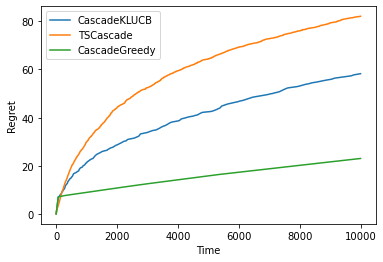

--- 1013.1864140033722 seconds ---


In [18]:
start_time = time.time()

plt.figure()

for algo in algorithms:
    print('Start evaluation', algo.__class__.__name__)
    ev = EvaluationBayesCascadeMAB(envs, algo, horizon)
    mean_regret = ev.mean_regret()
    std_regret = ev.std_regret()
    print('Regret of', algo.__class__.__name__, ':', mean_regret[-1], '+-', std_regret[-1], '\n')
    
    plt.plot(np.arange(horizon), mean_regret)
    #plt.fill_between(np.arange(horizon), mean_regret-std_regret, mean_regret+std_regret, alpha=.2)
    plt.xlabel('Time')
    plt.ylabel('Regret')

plt.legend([algo.__class__.__name__ for algo in algorithms], loc=0)
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))